 
В данном задании требуется разобраться с библиотекой Gym, которую не проходили в рамках учебных материалов -  требуется реализовать классический алгоритм Q-обучения на среде 'Taxi-v3' - т.е. нельзя использовать нейронные сети, нужно использовать Q-таблицу. В данной среде всего 500 уникальных состояний, так что Q-таблица будет работать лучше и обучаться намного быстрее, чем нейронная сеть. 

Нужную документацию можно найти по следующей ссылке: https://gym.openai.com/envs/Taxi-v3/

Импортируем библиотеку gym.

In [ ]:
import gym         #Импортируем библиотеку gym (встроенная в колаб)
import numpy as np #Импортируем numpy
import tensorflow as tf                    #Импортируем тензорфлоу
import matplotlib.pyplot as plt            #Импортируем pyplot для визуализации данных
import pickle                              #Импортируем модуль pickle для сохранения и загрузки данных
import random                              #Импортируем модуль для генерации рандомных чисел
from moviepy.editor import *               #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
import cv2                                 #Импортируем библиотеку cv2 (используется для воспроизведение видео)
from google.colab import output            #Импортируем функцию для управления вывода в колаб-ячейках

#Импортируем тип данных deque из встроенного модуля питона
from collections import deque   #deque - это список где автоматический удаляются старые значения при добовлении новых, чтобы не было переполнение памяти.
from IPython.display import clear_output
from time import sleep

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1376256/45929032 bytes (3.0%)3309568/45929032 bytes (7.2%)5873664/45929032 bytes (12.8%)8183808/45929032 bytes (17.8%)10625024/45929032 bytes (23.1%)13017088/45929032 bytes (28.3%)15040512/45929032 bytes (32.7%)17399808/45929032 bytes (37.9%)20127744/45929032 bytes (43.8%)22544384/45929032 bytes (49.1%)24215552/45929032 bytes (52.7%)25927680/45929032 bytes (56.5%)276

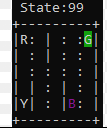

Мы будем взаимодействовать со средой, которая называется `taxi-v3`. Агент управляет такси, которая должна забирать пассажиров и доставлять их в указанные точки. Агент имеет 6 действий (забирать, доставлять, двигаться влево, двигаться вправо, двигаться вверх, двигаться вниз).

За неправильные действия (не взял пассажира, не туда сбросил пассажира, слишком долго вёз пассажира) назначаются отрициательные наргады. За своевременную доставку пассажира в нужное назначение даются положительные награды. По этому, цель алгоритма - обучиться правильно забирать и доставлять пассажиров.

In [ ]:
env = gym.make('Taxi-v3')          #Создаем игровую среду через библиотеку gym
state = env.reset()                #Начинаем новый эпизод, извлекаем состояние
print("Пример состояния:", state)  #Отображаем пример состояние (будет скалярное число)
print("Пространство действий:", env.action_space) #Смотрим на размер пространства действий - всего 6 дискретных действий можно совершить

Пример состояния: 64
Пространство действий: Discrete(6)


In [ ]:
print("Всего", env.observation_space.n, "уникальных состояний")
print("Всего", env.action_space.n, "дискретных действий")

Всего 500 уникальных состояний
Всего 6 дискретных действий


In [ ]:
# создадим Q-таблицу и заполним ее нулями
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [ ]:
training_episodes = 5000 # количество эпизодов для тренировки.
display_episodes = 10 # количество эпизодов после тренировки, для визуализации игры.

In [ ]:
# определим некоторые гиперпараметры
alpha = 0.1 # Learning Rate
gamma = 0.6 # Коэффициент учета будущих награждений
epsilon = 0.1 # Параметр случайного хода Epsilon Greedy

In [ ]:
# Обучаем агента на 5000 эпизодов
for i in range(training_episodes):
    state = env.reset() # состояние среды
    done = False
    penalties, reward, = 0, 0
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Берем новое действие для этого состояния
        else:
            action = np.argmax(q_table[state]) # Аргмаксом получаем индекс  наибольшего значения из q_table

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action] # Получаем текущее значение из q-table.
        next_max = np.max(q_table[next_state])

        # Обновляем q-value для текущего состояния
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10: # проверяем, не совершил ли агент наказуемое действие.
            penalties += 1

        state = next_state
        
    if i % 1000 == 0: # количество отработанных алгоритмом вариантов (показывается каждые 1000 эпох)
        print(f"Эпизод: {i}")

print("Обучение завершено.\n")

Эпизод: 0
Эпизод: 1000
Эпизод: 2000
Эпизод: 3000
Эпизод: 4000
Обучение завершено.



In [ ]:
# Тестируем результат после Q-learning

total_epochs, total_penalties = 0, 0

# для каждого эпизода игры
for _ in range(display_episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1
        clear_output(wait = True) 
        env.render()
        print(f"Шаг: {epochs}")
        print(f"Состояние: {state}")
        print(f"Действие: {action}")
        print(f"Награда: {reward}")
        sleep(0.15) # задержка для комфортной визуализации 

    total_penalties += penalties
    total_epochs += epochs
print(f"-----------------------------------------")
print(f"результат после {display_episodes} эпизодов:")
print(f"Среднее количество шагов в эпизодах: {total_epochs / display_episodes}")
print(f"Средний штраф за эпизод: {total_penalties / display_episodes}")

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Шаг: 200
Состояние: 488
Действие: 0
Награда: -1
-----------------------------------------
результат после 10 эпизодов:
Среднее количество шагов в эпизодах: 105.1
Средний штраф за эпизод: 0.0


Алгоритм обучился плохо. Видимо, 5 000 эпох было недостаточно. Среднее количество шагов в эпизодах = 105, это очень много. Попробуем дообучить алгоритм еще на 10 000 эпохах и посмотрим, улучшит ли это способность алгоритма находить кратчайшие пути к цели

In [ ]:
# Добучим агента еще на 10000 эпизодов
for i in range(10000):
    state = env.reset() # состояние среды
    done = False
    penalties, reward, = 0, 0
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Берем новое действие для этого состояния
        else:
            action = np.argmax(q_table[state]) # Аргмаксом получаем индекс  наибольшего значения из q_table

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action] # Получаем текущее значение из q-table.
        next_max = np.max(q_table[next_state])

        # Обновляем q-value для текущего состояния
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10: # проверяем, не совершил ли агент наказуемое действие.
            penalties += 1

        state = next_state
        
    if i % 1000 == 0: # количество отработанных алгоритмом вариантов (показывается каждые 1000 эпох)
        print(f"Эпизод: {i}")

print("Обучение завершено.\n")

Эпизод: 0
Эпизод: 1000
Эпизод: 2000
Эпизод: 3000
Эпизод: 4000
Эпизод: 5000
Эпизод: 6000
Эпизод: 7000
Эпизод: 8000
Эпизод: 9000
Обучение завершено.



In [ ]:
# Тестируем результат после 15000 эпизодов обучения Q-learning

total_epochs, total_penalties, total_reward = 0, 0, 0

# для каждого эпизода игры
for _ in range(display_episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        reward_all=0
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)
        reward_all+=reward
        if reward == -10:
            penalties += 1

        epochs += 1
        clear_output(wait = True) 
        env.render()
        print(f"Шаг: {epochs}")
        print(f"Состояние: {state}")
        print(f"Действие: {action}")
        print(f"Награда: {reward}")
        print(f"Общая награда: {reward_all}")
        sleep(0.15) # задержка для комфортной визуализации 

    total_penalties += penalties
    total_epochs += epochs
    total_reward+=reward_all
print(f"-----------------------------------------")
print(f"результат после {display_episodes} эпизодов:")
print(f"Среднее количество шагов в эпизодах: {total_epochs / display_episodes}")
print(f"Средний штраф за эпизод: {total_penalties / display_episodes}")
print(f"Средняя награда за эпизод: {total_reward / display_episodes}")

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Шаг: 15
Состояние: 410
Действие: 5
Награда: 20
Общая награда: 20
-----------------------------------------
результат после 10 эпизодов:
Среднее количество шагов в эпизодах: 12.6
Средний штраф за эпизод: 0.0
Средняя награда за эпизод: 20.0


Дообучение помогло. Среднее количество шагов в эпизодах удалось сократить до 12. Вероятно, дальшейшее дообучение может помочь еще сократить этот показатель (но это не точно))))

В итоге, можно сделать вывод, что алгоритм очень быстро научился избегать наказания - штрафа в -10 очков, но долго обучался находить самые короткие пути к цели.